# 00_preprocess_counts

Merge barcode counts from biological replicates into 1 dataframe. Filter barcodes with minimum >= 5 reads in the DNA library, and filter elements with minimum >= 3 barcodes represented. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def import_dna(counts_dir, dna_f):
    dna_dfs = []
    for i in range(len(dna_f)):
        f = dna_f[i]
        cols = ["barcode", "dna_%s" % (i+1)]
        tmp = pd.read_table("%s/%s" % (counts_dir, f), sep="\t")
        tmp.columns = cols
        dna_dfs.append(tmp)
    if len(dna_dfs) > 1:
        dna = reduce(lambda x, y: pd.merge(x, y, on = "barcode"), dna_dfs)
    else:
        dna = dna_dfs[0]
    return dna

In [5]:
def import_rna(counts_dir, rna_f, dna):
    data = dna.copy()
    data_cols = list(dna.columns)
    for f in rna_f:
        rep = re.findall(r'\d+', f.split("__")[1])[0]
        tmp = pd.read_table("%s/%s" % (counts_dir, f), sep="\t")
        tmp.columns = ["barcode", "rna_%s" % rep]
        data_cols.append("rna_%s" % rep)
        data = data.merge(tmp, on="barcode", how="outer")
    return data, data_cols

## Variables

In [6]:
counts_dir = "../../../data/01_counts/"

In [7]:
barcode_dna_read_threshold = 5
barcode_rna_read_threshold = 0
n_barcodes_per_elem_threshold = 3

### DNA files

In [8]:
dna_f = ["PM_Hyp_pooled_cl2_08102019_R1_BARCODES.txt"]

### RNA files

In [9]:
VSMC_rna_f = ["PM_VSMC_21d_rep2_20200109__rep1__R1_BARCODES.txt","PM_VSMC_24d_rep1_20200109__rep2__R1_BARCODES.txt",
              "PM_VSMC_24d_rep3_20200109__rep3__R1_BARCODES.txt","PM_VSMC_P8rep2_20191213__rep4__R1_BARCODES.txt",
             "PM_VSMC_P8rep3_20191213__rep5__R1_BARCODES.txt"]

In [95]:
VSMC_out_f = "VSMC__all_counts_noMerging.txt"

### Index file

In [11]:
index_f = "../../../data/design/Hypertension__pooled.index.txt"

## 1. import index

In [12]:
index = pd.read_table(index_f, sep='\t')

In [13]:
index.head()

,element,tile_type,tile_id,name,parse_details,chrom,start,end,strand,actual_start,...,RE_1,RE_2,RE_3,REs_mutated,unique_name,snp,barcode,oligo,oligo_len,pool_num
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CTGCTTGATAC,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
1,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.2,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CTCGGCGAACA,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
2,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.3,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CATGTTCGAGT,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
3,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.4,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,ATCGTAAACTC,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
4,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.5,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,ATAGGTTCGCT,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1


In [14]:
n_barc = len(index)
n_barc

239450

In [15]:
index_elem = index[["element", "tile_type"]].drop_duplicates()

## 2. import dna

In [16]:
dna = import_dna(counts_dir, dna_f)
dna.head()

,barcode,dna_1
0,TAATTTGCGTG,497
1,GGTATGTCGGC,255
2,GTCGTCAATAA,245
3,CCGCATTTAAT,4
4,ATAACATAGGC,46


## 3. import rna

In [68]:
VSMC_data, VSMC_cols = import_rna(counts_dir, VSMC_rna_f, dna)
VSMC_data.head()

,barcode,dna_1,rna_1,rna_2,rna_3,rna_4,rna_5
0,TAATTTGCGTG,497,198,1,103,241,2
1,GGTATGTCGGC,255,0,190,0,113,1
2,GTCGTCAATAA,245,105,255,20,132,0
3,CCGCATTTAAT,4,0,3,0,1,0
4,ATAACATAGGC,46,0,0,0,1,0


In [69]:
VSMC_cols

['barcode', 'dna_1', 'rna_1', 'rna_2', 'rna_3', 'rna_4', 'rna_5']

In [70]:
VSMC_data.columns = ["barcode", "dna_1", "VSMC_rep1_21d", "VSMC_rep1_24d_2", "VSMC_rep1_24d_3",
                       "VSMC_rep2_P8_4", "VSMC_rep2_P8_5"]

## 4. heatmap showing replicate corrs and clustering

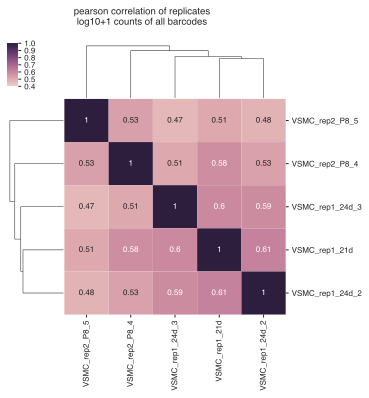

In [24]:
tmp = VSMC_data
tmp = tmp.set_index("barcode")
tmp.drop("dna_1", axis=1, inplace=True)
tmp_cols = tmp.columns
tmp[tmp_cols] = np.log10(tmp[tmp_cols] + 1)
tmp_corr = tmp.corr(method="pearson")

cmap = sns.cubehelix_palette(as_cmap=True)
cg = sns.clustermap(tmp_corr, figsize=(5, 5), cmap=cmap, annot=True, vmin=0.4)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.suptitle("pearson correlation of replicates\nlog10+1 counts of all barcodes")

cg.savefig("rep_and_lib_corr_heatmap.svg", dpi="figure", bbox_inches="tight")

## 5. merge technical replicates

In [24]:
VSMC_data["rep1"] = VSMC_data[["VSMC_rep1_21d"]].sum(axis=1)
VSMC_data["rep2"] = VSMC_data[["VSMC_rep1_24d_3", "VSMC_rep1_24d_2"]].sum(axis=1)
VSMC_data["rep3"] = VSMC_data[["VSMC_rep2_P8_5", "VSMC_rep2_P8_4"]].sum(axis=1)

old_cols = [x for x in VSMC_data.columns if "VSMC_" in x]
VSMC_data.drop(old_cols, axis=1, inplace=True)
VSMC_data.columns = ["barcode", "dna_1", "rep_1", "rep_2", "rep_3"]
VSMC_data.head()

,barcode,dna_1,rep_1,rep_2,rep_3
0,TAATTTGCGTG,497,198,104,243
1,GGTATGTCGGC,255,0,190,114
2,GTCGTCAATAA,245,105,275,132
3,CCGCATTTAAT,4,0,3,1
4,ATAACATAGGC,46,0,0,1


In [25]:
VSMC_data[["rep_1", "rep_2", "rep_3"]].sum(axis=0)

rep_1     48766975
rep_2     79591814
rep_3    117768668
dtype: int64

## 5. filter barcodes

In [71]:
VSMC_data = VSMC_data.fillna(0)

In [72]:
VSMC_data_filt = VSMC_data[VSMC_data["dna_1"] >= barcode_dna_read_threshold]
VSMC_data_filt.set_index("barcode", inplace=True)

In [73]:
VSMC_reps = [x for x in VSMC_data_filt.columns if "VSMC_" in x]

In [74]:
VSMC_data_filt[VSMC_reps] =  VSMC_data_filt[VSMC_reps].astype(int)

In [75]:
VSMC_data_filt[VSMC_reps] = VSMC_data_filt[VSMC_data_filt[VSMC_reps] > barcode_rna_read_threshold][VSMC_reps]
VSMC_data_filt.reset_index(inplace=True)
VSMC_data_filt.head()

,barcode,dna_1,VSMC_rep1_21d,VSMC_rep1_24d_2,VSMC_rep1_24d_3,VSMC_rep2_P8_4,VSMC_rep2_P8_5
0,TAATTTGCGTG,497,198.0,1.0,103.0,241.0,2.0
1,GGTATGTCGGC,255,NaN,190.0,NaN,113.0,1.0
2,GTCGTCAATAA,245,105.0,255.0,20.0,132.0,NaN
3,ATAACATAGGC,46,NaN,NaN,NaN,1.0,NaN
4,ACATTTCGAGG,753,909.0,11.0,8.0,NaN,NaN


In [76]:
all_names = ["VSMC"]

all_dfs = [VSMC_data_filt]

all_cols = [VSMC_data.columns]


print("FILTERING RESULTS:")
for n, df, cs in zip(all_names, all_dfs, all_cols):
    index_len = len(index)
        
    dna_barc_len = len(df)
    dna_barc_perc = (float(dna_barc_len)/index_len)*100
    
    print("%s: from %s barcodes to %s at DNA level (%s%%)" % (n, index_len, dna_barc_len, dna_barc_perc))
    
    reps = [x for x in cs if "VSMC_" in x]
    
    for r in reps:
        rep = r.split("_")[1]
        
        rna_barc_len = sum(~pd.isnull(df[r]))
        rna_barc_perc = (float(rna_barc_len)/index_len)*100
        
        print("\trep %s: %s barcodes at RNA level (%s%%)" % (rep, rna_barc_len, rna_barc_perc))
    print("")

FILTERING RESULTS:
VSMC: from 239450 barcodes to 195533 at DNA level (81.65921904364168%)
	rep rep1: 112418 barcodes at RNA level (46.94842347045312%)
	rep rep1: 98941 barcodes at RNA level (41.32010858216747%)
	rep rep1: 97671 barcodes at RNA level (40.78972645646273%)
	rep rep2: 111194 barcodes at RNA level (46.43725203591564%)
	rep rep2: 95451 barcodes at RNA level (39.862601795782%)



## 6. filter elements

In [77]:
VSMC_data_filt = VSMC_data_filt.merge(index, on="barcode", how="inner")

In [78]:
VSMC_barcodes_per_elem = VSMC_data_filt.groupby(["unique_name", "tile_type"])["barcode"].agg("count").reset_index()
VSMC_barcodes_per_elem_neg = VSMC_barcodes_per_elem[VSMC_barcodes_per_elem["tile_type"].isin(["RANDOM", "SCRAMBLED"])]
VSMC_barcodes_per_elem_no_neg = VSMC_barcodes_per_elem[~VSMC_barcodes_per_elem["tile_type"].isin(["RANDOM", "SCRAMBLED"])]

VSMC_barcodes_per_elem_no_neg_filt = VSMC_barcodes_per_elem_no_neg[VSMC_barcodes_per_elem_no_neg["barcode"] >= n_barcodes_per_elem_threshold]
VSMC_total_elems_rep = len(VSMC_barcodes_per_elem_no_neg)
VSMC_total_elems_filt_rep = len(VSMC_barcodes_per_elem_no_neg_filt)

In [79]:
index['tile_type'].unique()

array(['WILDTYPE_BUT_HAS_SNP', 'WILDTYPE_SNP_INDIV',
       'CONTROL_BUT_HAS_SNP', 'CONTROL_SNP_INDIV', 'RANDOM'], dtype=object)

In [80]:
print("ELEMENT FILTERING RESULTS:")
print("VSMC: filtered %s elements to %s represented at >= %s barcodes (%s%%)" % (VSMC_total_elems_rep, VSMC_total_elems_filt_rep,
                                                                                   n_barcodes_per_elem_threshold,
                                                                                   float(VSMC_total_elems_filt_rep)/VSMC_total_elems_rep*100))

ELEMENT FILTERING RESULTS:
VSMC: filtered 9380 elements to 9321 represented at >= 3 barcodes (99.37100213219617%)


In [81]:
VSMC_good_elems = list(VSMC_barcodes_per_elem_no_neg["unique_name"]) + list(VSMC_barcodes_per_elem_neg["unique_name"])

In [82]:
VSMC_data_filt = VSMC_data_filt[VSMC_data_filt["unique_name"].isin(VSMC_good_elems)]

## 7. heatmap comparing barcode counts

In [83]:
VSMC_cols = ["barcode"]

In [84]:
VSMC_cols.extend(["%s" % x for x in VSMC_reps])
VSMC_cols

['barcode',
 'VSMC_rep1_21d',
 'VSMC_rep1_24d_2',
 'VSMC_rep1_24d_3',
 'VSMC_rep2_P8_4',
 'VSMC_rep2_P8_5']

In [85]:
VSMC_counts = VSMC_data_filt.copy()
VSMC_counts.head()

,barcode,dna_1,VSMC_rep1_21d,VSMC_rep1_24d_2,VSMC_rep1_24d_3,VSMC_rep2_P8_4,VSMC_rep2_P8_5,element,tile_type,tile_id,...,tile_end,RE_1,RE_2,RE_3,REs_mutated,unique_name,snp,oligo,oligo_len,pool_num
0,TAATTTGCGTG,497,198.0,1.0,103.0,241.0,2.0,TGTGGTACTTCCCCCTTAGTTCTCCTGTCTCTCTCCTGCTCCTCCA...,WILDTYPE_BUT_HAS_SNP,1719.1.0.0.0.0.8,...,135,0,1,0,none,chr1:217721267:217721402__rs12043318__1:217721...,none,ACTGGCCGCTTCACTGTGTGGTACTTCCCCCTTAGTTCTCCTGTCT...,191,1
1,GGTATGTCGGC,255,NaN,190.0,NaN,113.0,1.0,TCGGGAGGCTGATGCAGGAGAATCGCTTGAATCTGGGAGGTGGAGT...,WILDTYPE_BUT_HAS_SNP,1956.1.0.0.0.0.1,...,135,0,1,0,none,chr3:133914680:133914815__rs9882168__3:1339147...,none,ACTGGCCGCTTCACTGTCGGGAGGCTGATGCAGGAGAATCGCTTGA...,191,1
2,GTCGTCAATAA,245,105.0,255.0,20.0,132.0,NaN,CCCTCAATCCAAGTCAATGGCCTCCTGAGAGCTCCATATGACCAGC...,WILDTYPE_SNP_INDIV,1267.1.0.68.0.0.8,...,135,0,1,0,none,chr3:47997758:47997893__rs71625844__3:47997826...,rs71625844,ACTGGCCGCTTCACTGCCCTCAATCCAAGTCAATGGCCTCCTGAGA...,189,1
3,ATAACATAGGC,46,NaN,NaN,NaN,1.0,NaN,TTTTATGTGAAAATGAAGCTCTATAACAACCAAGTCAGGGGACCTA...,WILDTYPE_BUT_HAS_SNP,2550.1.0.0.0.0.11,...,135,0,1,0,none,chr16:75360028:75360163__rs8046109__16:7536009...,none,ACTGGCCGCTTCACTGTTTTATGTGAAAATGAAGCTCTATAACAAC...,191,2
4,ACATTTCGAGG,753,909.0,11.0,8.0,NaN,NaN,TTGCATTGAGATAATGGTAGATTCACATTCATTTCTAAGAAATAAT...,WILDTYPE_SNP_INDIV,4423.1.0.68.0.0.25,...,135,0,1,0,none,chr3:42052864:42052999__rs794892__3:42052932:G...,rs794892,ACTGGCCGCTTCACTGTTGCATTGAGATAATGGTAGATTCACATTC...,191,2


In [87]:
VSMC_counts = VSMC_counts[VSMC_cols]
VSMC_counts.head()

,barcode,VSMC_rep1_21d,VSMC_rep1_24d_2,VSMC_rep1_24d_3,VSMC_rep2_P8_4,VSMC_rep2_P8_5
0,TAATTTGCGTG,198.0,1.0,103.0,241.0,2.0
1,GGTATGTCGGC,NaN,190.0,NaN,113.0,1.0
2,GTCGTCAATAA,105.0,255.0,20.0,132.0,NaN
3,ATAACATAGGC,NaN,NaN,NaN,1.0,NaN
4,ACATTTCGAGG,909.0,11.0,8.0,NaN,NaN


In [88]:
VSMC_counts.columns = VSMC_cols
VSMC_reps

['VSMC_rep1_21d',
 'VSMC_rep1_24d_2',
 'VSMC_rep1_24d_3',
 'VSMC_rep2_P8_4',
 'VSMC_rep2_P8_5']

In [89]:
VSMC_counts.head()

,barcode,VSMC_rep1_21d,VSMC_rep1_24d_2,VSMC_rep1_24d_3,VSMC_rep2_P8_4,VSMC_rep2_P8_5
0,TAATTTGCGTG,198.0,1.0,103.0,241.0,2.0
1,GGTATGTCGGC,NaN,190.0,NaN,113.0,1.0
2,GTCGTCAATAA,105.0,255.0,20.0,132.0,NaN
3,ATAACATAGGC,NaN,NaN,NaN,1.0,NaN
4,ACATTTCGAGG,909.0,11.0,8.0,NaN,NaN


In [90]:
all_samples = VSMC_counts
all_samples.drop("barcode", axis=1, inplace=True)
cols = [x for x in VSMC_cols if x != "barcode"]
all_samples[cols] = np.log10(all_samples[cols]+1)
all_samples_corr = all_samples.corr(method="pearson")

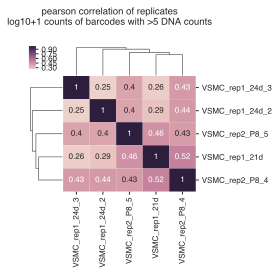

In [91]:
cmap = sns.cubehelix_palette(as_cmap=True)
cg = sns.clustermap(all_samples_corr, figsize=(3,3), cmap=cmap, annot=True)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.suptitle("pearson correlation of replicates\nlog10+1 counts of barcodes with >5 DNA counts")
plt.subplots_adjust(top=0.8)
cg.savefig("Pearson_corr_DNAfilter_noMerging.svg", dpi="figure", transparent=True, bbox_inches="tight")

## 10. write final files

In [93]:
VSMC_counts = VSMC_data_filt[VSMC_data.columns]

In [94]:
VSMC_counts.head()

,barcode,dna_1,VSMC_rep1_21d,VSMC_rep1_24d_2,VSMC_rep1_24d_3,VSMC_rep2_P8_4,VSMC_rep2_P8_5
0,TAATTTGCGTG,497,198.0,1.0,103.0,241.0,2.0
1,GGTATGTCGGC,255,NaN,190.0,NaN,113.0,1.0
2,GTCGTCAATAA,245,105.0,255.0,20.0,132.0,NaN
3,ATAACATAGGC,46,NaN,NaN,NaN,1.0,NaN
4,ACATTTCGAGG,753,909.0,11.0,8.0,NaN,NaN


In [96]:
VSMC_counts.to_csv("%s/%s" % (counts_dir, VSMC_out_f), sep="\t", header=True, index=False)

In [92]:
VSMC_data.columns

Index(['barcode', 'dna_1', 'VSMC_rep1_21d', 'VSMC_rep1_24d_2',
       'VSMC_rep1_24d_3', 'VSMC_rep2_P8_4', 'VSMC_rep2_P8_5'],
      dtype='object')